<a href="https://colab.research.google.com/github/dryanguasr/ColabProjects/blob/main/Proyecto_Regresi%C3%B3n_precio_de_acciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión de series de tiempo de acciones
El presente proyecto presenta un primer acercamiento a la predicción de series de tiempo de acciones de bolsa. En particular se tomó como caso de estudio la predicción de los valores de cambio de las acciones a partir de las cuales se calcula el indice Dow Jones.

## Objetivos del negocio






Datos obtenidos de [Kaggle](https://www.kaggle.com/dantest232/dow-jones-1jan2000-to-6dec2017)



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, f1_score


Company_Names = ['3M', 'American Express', 'Apple', 'Boeing', 'Caterpillar',
                 'Chevron', 'Cisco Systems', 'Coca-Cola', 'DowDuPont', 'ExxonMobil',
                 'General Electric', 'Goldman Sachs', 'IBM', 'Intel', 'JPMorgan Chase',
                 'Johnson & Johnson', 'McDonalds', 'Merck', 'Microsoft', 'Nike',
                 'Pfizer', 'Procter & Gamble', 'The Home Depot', 'Travelers', 'United Technologies', 
                 'UnitedHealth Group', 'Verizon', 'Visa', 'Walmart', 'Walt Disney']
# Company_Names = ['3M']
companies = {}
for name in Company_Names:
  company = pd.read_csv(name+'.csv')
  company.fillna(method='ffill', inplace=True)
  company.set_index(['Date'],inplace=True)
  company['Daily Change'] = company['Close'] - company['Open']
  company['Open diff'] = company['Open'].diff()
  company['Close diff'] = company['Close'].diff()
  companies[name] = company

print(companies['3M'].shape)
companies['3M'].head(10)

(4512, 9)


,Open,High,Low,Close,Adj Close,Volume,Daily Change,Open diff,Close diff
Date,,,,,,,,,
1999-12-31,48.40625,49.37500,48.00000,48.9375,31.750277,1021200,0.53125,NaN,NaN
2000-01-03,48.03125,48.25000,47.03125,47.1875,30.614885,2173400,-0.84375,-0.37500,-1.7500
2000-01-04,46.43750,47.40625,45.31250,45.3125,29.398392,2713800,-1.12500,-1.59375,-1.8750
2000-01-05,45.56250,48.12500,45.56250,46.6250,30.249941,3699400,1.06250,-0.87500,1.3125
2000-01-06,47.15625,51.25000,47.15625,50.3750,32.682892,5975800,3.21875,1.59375,3.7500
2000-01-07,50.56250,51.90625,49.96875,51.3750,33.331699,4101200,0.81250,3.40625,1.0000
2000-01-10,50.21875,51.75000,50.00000,51.1250,33.169502,3863800,0.90625,-0.34375,-0.2500
2000-01-11,50.37500,51.25000,50.25000,50.2500,32.601810,2357600,-0.12500,0.15625,-0.8750
2000-01-12,50.96875,51.81250,50.37500,50.3750,32.682892,2868400,-0.59375,0.59375,0.1250


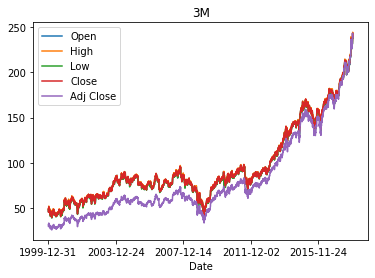

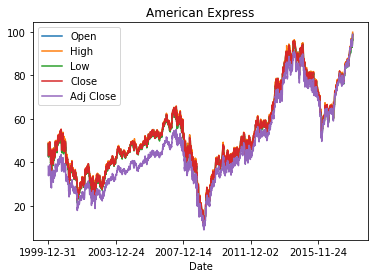

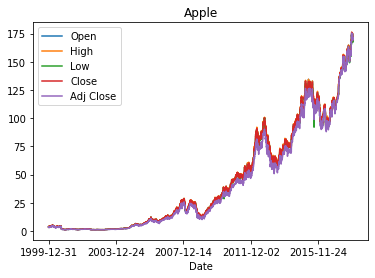

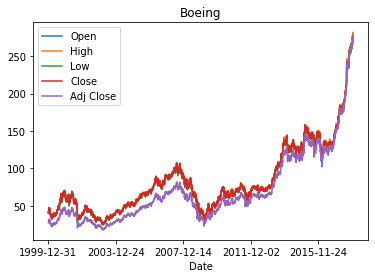

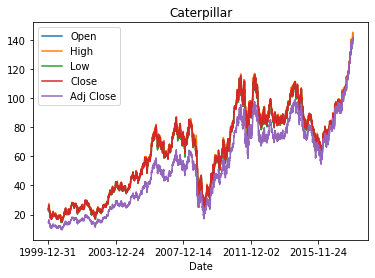

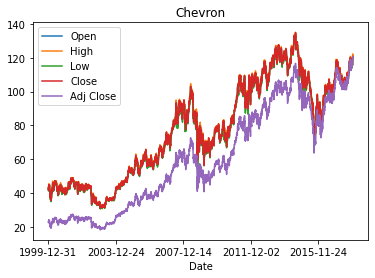

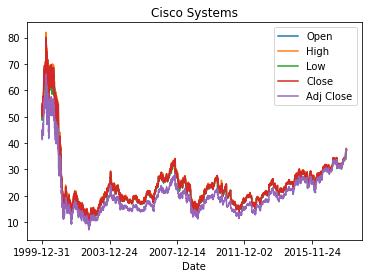

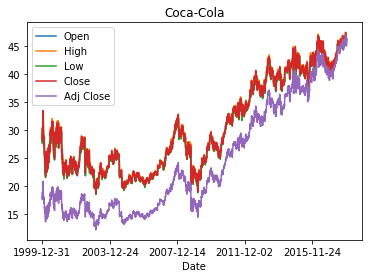

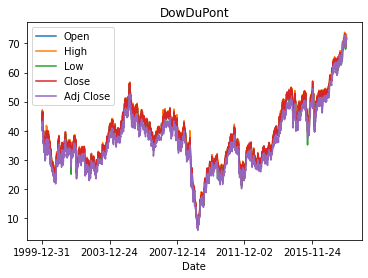

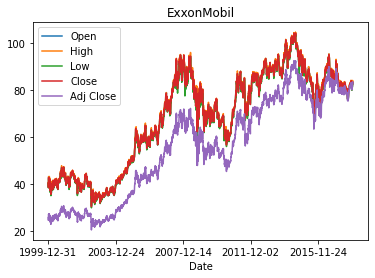

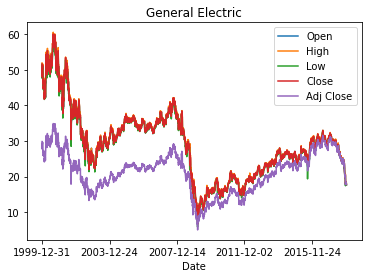

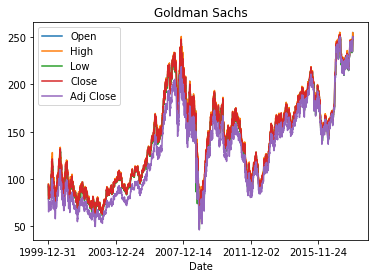

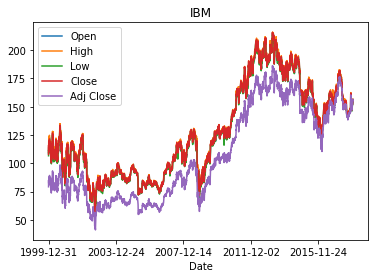

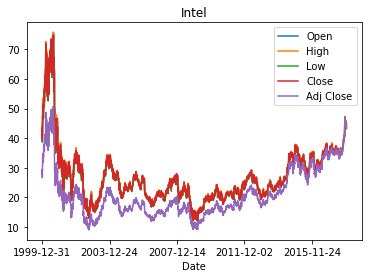

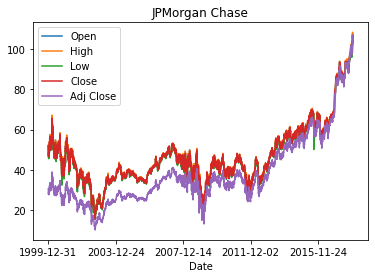

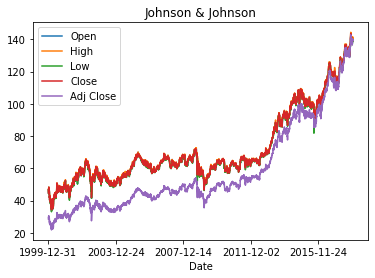

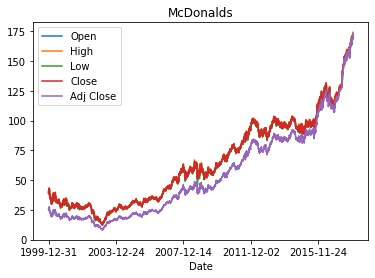

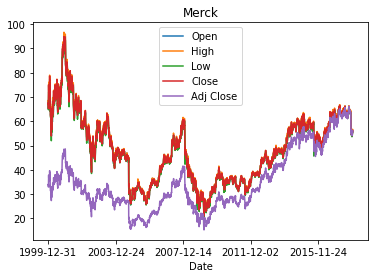

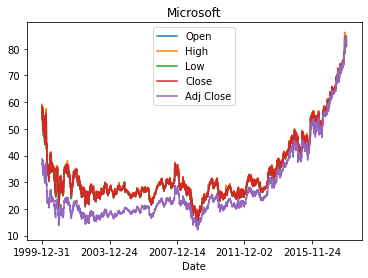

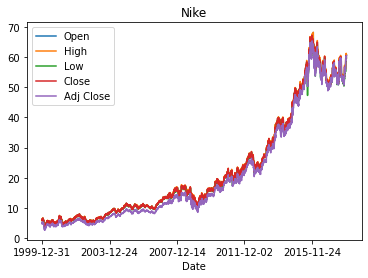

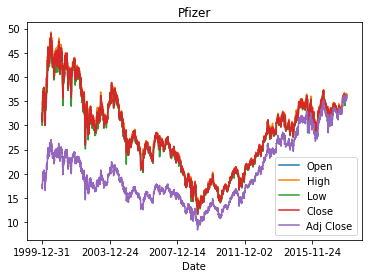

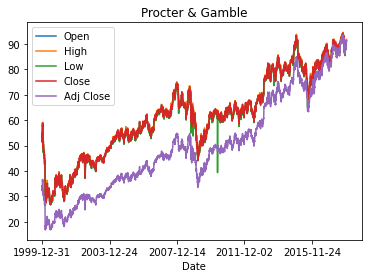

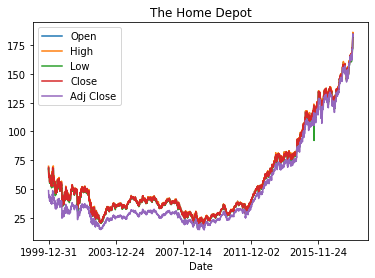

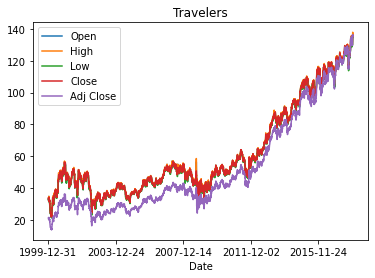

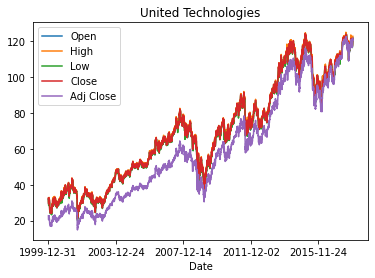

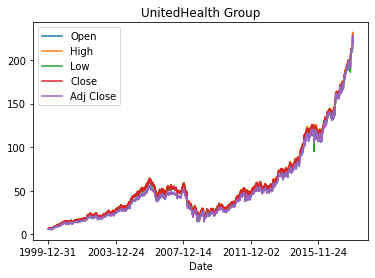

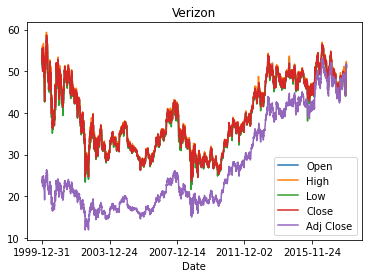

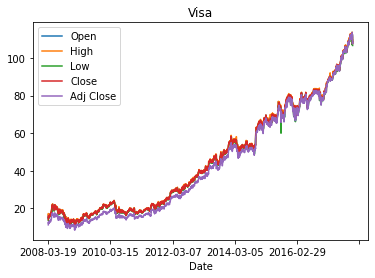

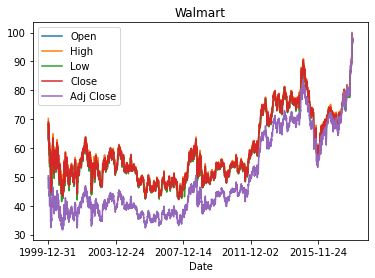

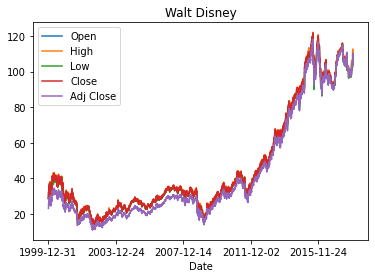

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})

for name in Company_Names:
  plt.figure()
  companies[name]['Open'].plot()
  companies[name]['High'].plot()
  companies[name]['Low'].plot()
  companies[name]['Close'].plot()
  companies[name]['Adj Close'].plot()
  plt.title(name)
  plt.legend()

In [ ]:
px.line(companies['3M'], x = companies['3M'].index,y = 'Daily Change')

In [ ]:
px.line(companies['3M'], x = companies['3M'].index,y = 'Open diff')

In [ ]:
px.line(companies['3M'], x = companies['3M'].index,y = 'Close diff')

# Particionamiento de datos y preprocesamiento

In [ ]:
def temporal_split(X, test_size):
  """
  Entradas:
    X : Arreglo de numpy con shape (n,), la serie de tiempo
    test_size : el porcentaje de datos destinados para la partición de prueba
  Retorna:
    tupla (X_train, X_test): las particiones de entrenamiento y prueba.
  """
  # Su código aquí
  N = round(len(X)*(1-test_size))
  X_train = X[0:N]
  X_test = X[N:]
  return X_train, X_test

def temporal_window(time_series, window_size):
  """
  Entradas:
    time_series : Arreglo de numpy con shape (n,), una serie de tiempo
  Retorna:
    (X, y) Las ventanas temporales como una tupla donde:
      X: Arreglo de numpy con shape(n - window_size, window_size): las ventanas temporales.
      y: Arreglo de numpy con shape(n - window_size,): el siguiente valor en la serie para cada ventana.
  """
  n = time_series.shape[0] - window_size  

  X = np.empty((n, window_size))
  y = np.empty(n)

  for i in range(window_size, time_series.shape[0]):   
    y[i - window_size] = time_series[i]
    X[i- window_size, 0:window_size] = np.array(time_series[i - window_size:i])
    
  return X, y

In [ ]:
def train(X_train, y_train, n_splits, clf, param_grid):
  """
  Entradas:
    X_train: Arreglo de numpy con shape (n, m)
    y_train: Arreglo de numpy con shape (n,)
    n_splits: el número de pliegues para TimeSeriesSplit.
    clf: instancia de un modelo sin entrenar
    param_grid: los hiperparámetros a explorar
  Retorna:
    GridSearchCV entrenado sobre X_train y y_train
  """
  # Su código aquí
  tsp = TimeSeriesSplit(n_splits=n_splits)
  gsearch = GridSearchCV(clf, 
                         cv = tsp,
                         param_grid = param_grid, 
                         verbose = 3)

  
  return gsearch.fit(X_train, y_train)

clf = clf = MLPRegressor(max_iter = 5000)
parameters = {'hidden_layer_sizes': [(20,20),(40,),(20,10,10)]}

X_train = {}
X_test = {}
X_train_window = {}
X_test_window = {}
y_train_window = {}
y_test_window = {}
for name in Company_Names:
  X_train[name], X_test[name] = temporal_split(companies[name]['Daily Change'], 0.2)
  X_train_window[name], y_train_window[name] = temporal_window(X_train[name], window_size = 50)
  X_test_window[name], y_test_window[name] = temporal_window(X_test[name], window_size = 50)


## Entrenamiento y validación Cruzada


In [ ]:
gsearch = {}
for name in Company_Names:
  gsearch[name] = train(X_train_window[name], y_train_window[name], 4, clf, parameters)
  print('El mejor coeficiente de determinación (validación) para ' + name + ' es\n: ' + str(gsearch[name].best_score_))
  print('Los mejores parámetros para ' + name + ' son :\n ' + str(gsearch[name].best_params_))


Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.643, total=   1.2s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.512, total=   3.8s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.329, total=   5.6s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.107, total=   6.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.146, total=   1.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.679, total=   4.7s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.934, total=   7.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.350, total=   9.0s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.850, total=   1.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   54.0s finished


El mejor coeficiente de determinación (validación) para 3M es
: -1.397535403609813
Los mejores parámetros para 3M son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.342, total=   1.0s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.404, total=   3.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.663, total=   4.5s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.148, total=   5.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.985, total=   1.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.498, total=   3.7s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.474, total=   6.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.195, total=   8.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.572, total=   1.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   47.7s finished


El mejor coeficiente de determinación (validación) para American Express es
: -1.2879814180858058
Los mejores parámetros para American Express son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.167, total=   0.1s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.556, total=   0.2s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.448, total=   0.7s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.240, total=   2.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.112, total=   0.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.417, total=   0.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.365, total=   0.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.906, total=   2.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-0.028, total=   0.1s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   10.4s finished


El mejor coeficiente de determinación (validación) para Apple es
: -0.4501065596245448
Los mejores parámetros para Apple son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.144, total=   1.1s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.807, total=   3.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.663, total=   5.3s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.249, total=   6.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.781, total=   1.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.289, total=   4.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.998, total=   6.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.118, total=   7.9s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.681, total=   1.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   55.5s finished


El mejor coeficiente de determinación (validación) para Boeing es
: -1.2965582754874725
Los mejores parámetros para Boeing son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.005, total=   0.8s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.588, total=   2.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.468, total=   4.2s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.029, total=   4.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.806, total=   0.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.536, total=   3.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.842, total=   6.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.459, total=   8.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-0.972, total=   0.9s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   44.2s finished


El mejor coeficiente de determinación (validación) para Caterpillar es
: -1.2724717840876436
Los mejores parámetros para Caterpillar son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.911, total=   0.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.161, total=   3.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.305, total=   4.3s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.071, total=   5.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.659, total=   1.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.328, total=   3.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.870, total=  13.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.118, total=   6.1s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.138, total=   1.0s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   51.5s finished


El mejor coeficiente de determinación (validación) para Chevron es
: -1.112262689641507
Los mejores parámetros para Chevron son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.688, total=   1.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.543, total=   2.7s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.392, total=   2.5s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.109, total=   3.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.807, total=   1.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.615, total=   3.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.595, total=   3.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.545, total=   4.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.511, total=   1.8s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   33.8s finished


El mejor coeficiente de determinación (validación) para Cisco Systems es
: -0.4332253370044999
Los mejores parámetros para Cisco Systems son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.825, total=   0.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.656, total=   1.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.686, total=   1.5s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.592, total=   2.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.750, total=   0.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.694, total=   1.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.451, total=   1.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.658, total=   2.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.134, total=   0.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   18.4s finished


El mejor coeficiente de determinación (validación) para Coca-Cola es
: -0.6382014453607578
Los mejores parámetros para Coca-Cola son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.182, total=   1.0s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.533, total=   2.7s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.562, total=   3.8s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.000, total=   4.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.099, total=   1.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.729, total=   3.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.699, total=   6.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.196, total=   7.1s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.354, total=   1.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   43.0s finished


El mejor coeficiente de determinación (validación) para DowDuPont es
: -1.319428855997276
Los mejores parámetros para DowDuPont son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.188, total=   0.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.415, total=   3.0s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.740, total=   4.5s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.939, total=   5.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.839, total=   1.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.529, total=   3.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.646, total=   6.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.860, total=   5.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.512, total=   1.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   42.2s finished


El mejor coeficiente de determinación (validación) para ExxonMobil es
: -1.218390355749367
Los mejores parámetros para ExxonMobil son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.675, total=   1.1s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.694, total=   2.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.815, total=   3.0s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.298, total=   4.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.925, total=   1.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.845, total=   3.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.071, total=   4.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.937, total=   5.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-6.019, total=   1.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   35.6s finished


El mejor coeficiente de determinación (validación) para General Electric es
: -0.870734044920035
Los mejores parámetros para General Electric son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.504, total=   1.8s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.219, total=   3.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.576, total=   7.1s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.195, total=   8.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.978, total=   1.7s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.268, total=   4.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-2.043, total=   7.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.419, total=   9.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.854, total=   1.8s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   59.4s finished


El mejor coeficiente de determinación (validación) para Goldman Sachs es
: -1.3735902046053479
Los mejores parámetros para Goldman Sachs son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.694, total=   1.7s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.196, total=   3.7s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-2.002, total=   6.5s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.131, total=   8.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.421, total=   1.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.192, total=   5.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.953, total=   7.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.253, total=   8.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.121, total=   2.0s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   59.1s finished


El mejor coeficiente de determinación (validación) para IBM es
: -1.4548403807157584
Los mejores parámetros para IBM son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.952, total=   1.4s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.840, total=   3.4s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.650, total=   3.3s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.273, total=   4.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.909, total=   1.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.981, total=   3.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.149, total=   4.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.870, total=   5.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.270, total=   1.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   37.9s finished


El mejor coeficiente de determinación (validación) para Intel es
: -0.6659073195665628
Los mejores parámetros para Intel son :
 {'hidden_layer_sizes': (20, 10, 10)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.540, total=   1.2s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.454, total=   3.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.803, total=   5.0s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.330, total=   6.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.162, total=   1.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.868, total=   3.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.298, total=   5.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.349, total=   7.2s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.406, total=   1.9s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   45.0s finished


El mejor coeficiente de determinación (validación) para JPMorgan Chase es
: -1.1692389977436672
Los mejores parámetros para JPMorgan Chase son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.186, total=   1.1s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.591, total=   3.1s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.007, total=   3.7s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.023, total=   4.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.937, total=   1.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.643, total=   3.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.186, total=   6.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.881, total=   5.9s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.755, total=   1.2s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   41.9s finished


El mejor coeficiente de determinación (validación) para Johnson & Johnson es
: -1.1619639542605968
Los mejores parámetros para Johnson & Johnson son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.043, total=   0.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.916, total=   2.0s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.325, total=   3.0s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.091, total=   5.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.833, total=   1.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.073, total=   2.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.578, total=   3.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.163, total=   6.1s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.132, total=   1.1s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   35.7s finished


El mejor coeficiente de determinación (validación) para McDonalds es
: -1.0938175852374274
Los mejores parámetros para McDonalds son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.442, total=   1.2s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.264, total=   4.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.067, total=   3.9s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.713, total=   5.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.221, total=   1.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.205, total=   3.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.592, total=   5.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.099, total=   7.0s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.538, total=   1.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   45.2s finished


El mejor coeficiente de determinación (validación) para Merck es
: -1.121224074005437
Los mejores parámetros para Merck son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-2.055, total=   0.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.755, total=   1.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.982, total=   2.4s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.680, total=   4.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.386, total=   1.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.715, total=   2.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.775, total=   3.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.917, total=   4.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.350, total=   1.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   32.4s finished


El mejor coeficiente de determinación (validación) para Microsoft es
: -0.9485508964772968
Los mejores parámetros para Microsoft son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.116, total=   0.2s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.162, total=   0.2s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.306, total=   0.4s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.197, total=   0.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.113, total=   0.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.180, total=   0.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.197, total=   0.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.354, total=   1.1s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-0.241, total=   0.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    5.2s finished


El mejor coeficiente de determinación (validación) para Nike es
: -0.19461727362261855
Los mejores parámetros para Nike son :
 {'hidden_layer_sizes': (20, 10, 10)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.554, total=   1.1s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.955, total=   2.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.845, total=   2.8s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.338, total=   3.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.683, total=   1.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.978, total=   3.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.081, total=   3.7s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.941, total=   4.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.957, total=   0.9s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   33.3s finished


El mejor coeficiente de determinación (validación) para Pfizer es
: -0.9207415521306987
Los mejores parámetros para Pfizer son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.048, total=   1.1s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.989, total=   2.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.166, total=   3.4s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.001, total=   5.0s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.854, total=   1.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.516, total=   3.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.269, total=   4.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.846, total=   6.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.362, total=   1.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   39.5s finished


El mejor coeficiente de determinación (validación) para Procter & Gamble es
: -1.050898660170711
Los mejores parámetros para Procter & Gamble son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.597, total=   1.2s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.110, total=   3.0s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.112, total=   4.3s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.017, total=   5.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.055, total=   1.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.240, total=   4.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.271, total=   4.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.220, total=   7.3s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.123, total=   1.5s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   45.1s finished


El mejor coeficiente de determinación (validación) para The Home Depot es
: -1.1967265737824389
Los mejores parámetros para The Home Depot son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.611, total=   1.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.557, total=   3.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.703, total=   4.0s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.941, total=   5.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.582, total=   1.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.574, total=   3.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.632, total=   5.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.353, total=   7.6s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.445, total=   1.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   45.7s finished


El mejor coeficiente de determinación (validación) para Travelers es
: -1.4529726028391492
Los mejores parámetros para Travelers son :
 {'hidden_layer_sizes': (20, 20)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.318, total=   1.0s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.631, total=   3.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.412, total=   4.0s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.956, total=   5.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.919, total=   1.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.331, total=   3.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.780, total=   6.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.364, total=   6.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.679, total=   1.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   45.5s finished


El mejor coeficiente de determinación (validación) para United Technologies es
: -1.2265501743749172
Los mejores parámetros para United Technologies son :
 {'hidden_layer_sizes': (20, 10, 10)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.840, total=   0.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.324, total=   1.8s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.513, total=   2.9s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.188, total=   4.3s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.507, total=   0.7s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.964, total=   2.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.433, total=   3.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.398, total=   6.8s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.272, total=   0.8s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   33.6s finished


El mejor coeficiente de determinación (validación) para UnitedHealth Group es
: -1.0756835581197577
Los mejores parámetros para UnitedHealth Group son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.634, total=   1.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.157, total=   3.3s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.289, total=   3.9s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.751, total=   4.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.997, total=   1.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.024, total=   3.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.197, total=   4.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.861, total=   6.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-2.324, total=   1.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   39.9s finished


El mejor coeficiente de determinación (validación) para Verizon es
: -1.0197106706591803
Los mejores parámetros para Verizon son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.708, total=   0.5s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.091, total=   0.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.151, total=   1.2s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-1.146, total=   1.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.596, total=   0.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.780, total=   0.8s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.940, total=   1.4s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.260, total=   1.9s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-0.872, total=   0.4s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.2s finished


El mejor coeficiente de determinación (validación) para Visa es
: -0.8940942440250452
Los mejores parámetros para Visa son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.355, total=   1.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.346, total=   3.6s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.557, total=   6.3s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.775, total=   5.2s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.895, total=   1.5s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.198, total=   4.1s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.215, total=   5.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-1.313, total=   9.0s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.944, total=   1.7s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   51.7s finished


El mejor coeficiente de determinación (validación) para Walmart es
: -1.155061183762333
Los mejores parámetros para Walmart son :
 {'hidden_layer_sizes': (40,)}
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ hidden_layer_sizes=(20, 20), score=-1.356, total=   0.9s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.737, total=   2.4s
[CV] hidden_layer_sizes=(20, 20) .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ........ hidden_layer_sizes=(20, 20), score=-0.980, total=   2.6s
[CV] hidden_layer_sizes=(20, 20) .....................................
[CV] ........ hidden_layer_sizes=(20, 20), score=-0.994, total=   3.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.792, total=   0.9s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.852, total=   2.7s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.834, total=   2.6s
[CV] hidden_layer_sizes=(40,) ........................................
[CV] ........... hidden_layer_sizes=(40,), score=-0.992, total=   4.8s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .... hidden_layer_sizes=(20, 10, 10), score=-1.326, total=   1.1s
[CV] hidden_layer_sizes=(20, 10, 10) .................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   31.3s finished


El mejor coeficiente de determinación (validación) para Walt Disney es
: -0.8674410270857027
Los mejores parámetros para Walt Disney son :
 {'hidden_layer_sizes': (40,)}


In [ ]:
for name in Company_Names:
  print('El mejor coeficiente de determinación (validación) para ' + name + ' es: ' + str(gsearch[name].best_score_))
  print('   Los mejores parámetros para ' + name + ' son : ' + str(gsearch[name].best_params_))


El mejor coeficiente de determinación (validación) para 3M es: -1.397535403609813
   Los mejores parámetros para 3M son : {'hidden_layer_sizes': (20, 20)}
El mejor coeficiente de determinación (validación) para American Express es: -1.2879814180858058
   Los mejores parámetros para American Express son : {'hidden_layer_sizes': (40,)}
El mejor coeficiente de determinación (validación) para Apple es: -0.4501065596245448
   Los mejores parámetros para Apple son : {'hidden_layer_sizes': (40,)}
El mejor coeficiente de determinación (validación) para Boeing es: -1.2965582754874725
   Los mejores parámetros para Boeing son : {'hidden_layer_sizes': (40,)}
El mejor coeficiente de determinación (validación) para Caterpillar es: -1.2724717840876436
   Los mejores parámetros para Caterpillar son : {'hidden_layer_sizes': (20, 20)}
El mejor coeficiente de determinación (validación) para Chevron es: -1.112262689641507
   Los mejores parámetros para Chevron son : {'hidden_layer_sizes': (20, 20)}
El me

In [ ]:
def predecir_futuro(pipe, ventana, n):
  """
  Entradas:
    clf: Modelo entrenado
    ventana: Arreglo de numpy con shape (k,) donde k es el tamaño de la ventana
    n: el número de pasos temporales a predecir
  Retorna:
    Una arreglo de numpy con shape (n,) con la predicción de los siguientes n valores
  """
  # Su código aquí
  k = len(ventana)
  y = np.zeros(n)
  X = ventana.copy()
  y[0] = pipe.predict(X.reshape(1,-1))[0]
  for i in range(1,n):
    X[0:k-1] = X[1:]
    X[k-1] = y[i-1]
    y[i] = pipe.predict(X.reshape(1,-1))[0]
  return y

from sklearn.metrics import accuracy_score, recall_score, f1_score
res_dict = {}
for name in Company_Names:
  ventana_id = 1
  n = 30
  ventana = X_test_window[name][ventana_id]
  y_true = y_test_window[name][ventana_id : ventana_id + n]>0
  y_pred = predecir_futuro(gsearch[name], ventana, n)>0
  acc_test = accuracy_score(y_true, y_pred)
  print('precisión de prueba para ' + name + ' {:.2f}'.format(acc_test))

precisión de prueba para 3M 0.47
precisión de prueba para American Express 0.43
precisión de prueba para Apple 0.57
precisión de prueba para Boeing 0.53
precisión de prueba para Caterpillar 0.57
precisión de prueba para Chevron 0.47
precisión de prueba para Cisco Systems 0.43
precisión de prueba para Coca-Cola 0.47
precisión de prueba para DowDuPont 0.47
precisión de prueba para ExxonMobil 0.67
precisión de prueba para General Electric 0.43
precisión de prueba para Goldman Sachs 0.43
precisión de prueba para IBM 0.40
precisión de prueba para Intel 0.50
precisión de prueba para JPMorgan Chase 0.60
precisión de prueba para Johnson & Johnson 0.53
precisión de prueba para McDonalds 0.43
precisión de prueba para Merck 0.37
precisión de prueba para Microsoft 0.47
precisión de prueba para Nike 0.53
precisión de prueba para Pfizer 0.60
precisión de prueba para Procter & Gamble 0.63
precisión de prueba para The Home Depot 0.43
precisión de prueba para Travelers 0.53
precisión de prueba para Uni